In [61]:
import math
import operator
import random

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import sympy
from deap import algorithms, base, creator, gp, tools


# CARGAR DATA SET

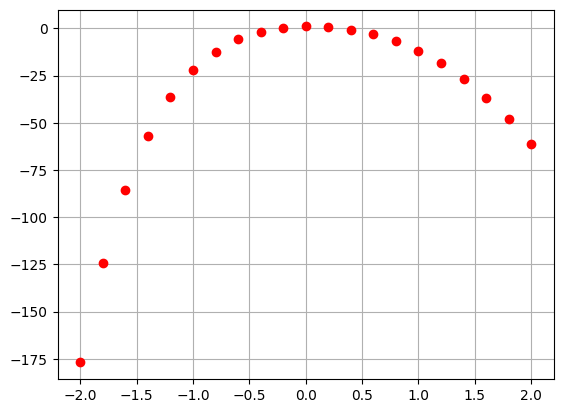

In [62]:

# Cargar el dataset
ruta = '/Users/ferleon/Github/semestre_v/algoritmos_bioinspirados/data/data.xlsx'
df_polar = pl.read_excel(ruta)

df = pl.read_excel(ruta)
x = df['x'].to_numpy()
y = df['y'].to_numpy()
plt.plot(x,y,'ro')
plt.grid()
plt.show()

# FUNCIÓN OBJETIVO

In [63]:
def function(x):
    return x**3 + x**2 + x + 1

# CONJUNTO DE PRIMITIVAS

In [64]:
primitive_set = gp.PrimitiveSet('MAIN', 1) # 1 variable de entrada
primitive_set.addPrimitive(operator.add, 2) # SUMA
primitive_set.addPrimitive(operator.sub, 2) # RESTA
primitive_set.addPrimitive(operator.mul, 2) # MULTIPLICA
primitive_set.addPrimitive(operator.neg, 1)    # NEGACIÓN CAMBIO DE SIGNO
primitive_set.addPrimitive(math.sin, 1)    # SENO
primitive_set.addPrimitive(math.cos, 1)    # COSENO
primitive_set.addEphemeralConstant("rand101", lambda: random.uniform(-1, 1)) # constantes aleatorias entre -1 y 1

# Renombrar variable de entrada
primitive_set.renameArguments(ARG0='x')

# DEFINIR EL TIPO DE FITNESS (minimizar el error)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)


# FUNCION PARA INICIALIZAR INDIVIDUOS Y POBLACION
toolbox = base.Toolbox()

toolbox.register('expr', gp.genHalfAndHalf, pset=primitive_set , min_=1, max_=2) # Generar expresiones
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr) # Inicializar individuos
toolbox.register('population', tools.initRepeat, list, toolbox.individual) # Inicializar poblacion


# FUNCION PARA EVALUAR INDIVIDUOS
toolbox.register("compile", gp.compile, pset=primitive_set) # Compilar el individuo

# FUNCION DE EVALUACION
data_points = df_polar['x'].to_list()
valores_objetivo = df_polar['y'].to_list()

def evaluar(individual):
    func = toolbox.compile(expr=individual)
    valores_individuo = [ func(x) for x in data_points ]
    # Calcular el error cuadratico medio
    mse = ((np.array(valores_individuo) - np.array(valores_objetivo))**2).mean()
    return mse,


# MECANISMOS EVOLUTIVOS
toolbox.register("evaluate", evaluar)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=primitive_set)


# SE LIMITA LA PROFUNDIDAD DE LOS INDIVIDUOS
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))


# =================== ALGORITMO EVOLUTIVO ===================
poblacion = toolbox.population(n=300)
hall_of_fame = tools.HallOfFame(1)

# Estadisticas de la evolucion
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


# Algoritmo evolutivo simple
algorithms.eaSimple(poblacion, toolbox, 0.5, 0.05, 100, stats=stats, halloffame=hall_of_fame, verbose=True)



print("Mejor individuo: ", hall_of_fame[0])
print()



# =================== PARA MEJORAR LA VISUALIZACION DEL INDIVIDUO ===================
x = sympy.symbols('x')


replacements = {
    "add": lambda a,b: a + b,
    "sub": lambda a,b: a - b,
    "mul": lambda a,b: a * b,
    "neg": lambda a: -a,
    "sin": sympy.sin,
    "cos": sympy.cos,
}


expr_str = str(hall_of_fame[0])
expr_sympy = sympy.sympify(expr_str, locals=replacements)

print(f"\nExpresión simbólica: {sympy.simplify(expr_sympy)}")

# Convertir el mejor individuo a una función de Python
func_mejor = toolbox.compile(expr=hall_of_fame[0])
print()



# Comparar con los valores originales
for x,y in zip(data_points, valores_objetivo):
    print(f"x={x:.2f} -> f(x)={y:.4f} | individuo(x)={func_mejor(x):.4f}")



gen	nevals	avg    	std    	min    	max    
0  	300   	3246.43	64.0676	3040.89	3495.82
1  	161   	3212.82	55.5757	3040.89	3657.35
2  	148   	3189.55	62.9231	3036.86	3655.4 
3  	153   	3162.28	55.6648	2993.98	3495.82
4  	133   	3143.52	61.0338	2993.98	3444.14
5  	155   	3117.82	60.3594	2942.56	3444.14
6  	143   	3105.13	90.9537	2756.92	3418.1 
7  	164   	3090.85	114.47 	2756.92	3694.93
8  	152   	3064.92	130.986	2599.35	3540.29
9  	147   	3006.64	138.465	2410.74	3954.96
10 	164   	2983.97	227.347	2274.26	4403.28
11 	149   	2858.48	250.629	2063.69	4269   
12 	168   	2801.56	482.955	712.262	6165.6 
13 	147   	2583.86	594.946	712.262	7198.01
14 	149   	2494.6 	2011.52	379.458	26826.2
15 	165   	2321.62	3400.35	211.956	45476.9
16 	162   	1796.06	4091.91	211.956	67844.2
17 	162   	1454.63	3959.79	211.956	61521  
18 	138   	1935.64	10641.2	210.255	156586 
19 	145   	3505.65	27798.1	197.918	405614 
20 	159   	8262.34	56881.6	190.491	715051 
21 	136   	2314.23	17817.4	190.491	237957 
22 	164   	

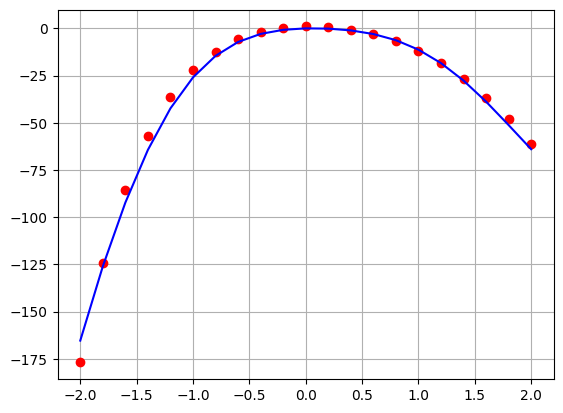

In [65]:




x = df['x'].to_numpy()
y = df['y'].to_numpy()


# Datos aproximados por el mejor individuo
y_aprox = [func_mejor(xi) for xi in x]


plt.plot(x,y,'ro')
plt.plot(x,y_aprox,'b-')
plt.grid()
plt.show()


